# LHS3844b's pandexo simulations of emission spectra models


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi # THIS IS THE HOLY GRAIL OF PANDEXO
import pandexo.engine.justplotit as jpi
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import astropy
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, ScalarFormatter, NullFormatter
from scipy.ndimage import gaussian_filter1d as gauss_conv
import pickle as pk
import numpy as np
import pandas as pd
import scipy.constants as sc
from spectres import spectres 
import copy

import matplotlib
#%matplotlib notebook

Setting up a run

In [3]:
exo_dict = jdi.load_exo_dict()
print(exo_dict.keys())
#print(exo_dict['star']['w_unit'])

dict_keys(['calculation', 'url', 'url_err', 'star', 'planet', 'observation'])


Exoplanet observation inputs

In [4]:
exo_dict['observation']['sat_level'] = 80    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = 1 #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 4*0.5212*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

Exoplanet host star inputs

In [5]:
'''
fits_image_filename = astropy.io.fits.open('./Resources/GJ1214_stellar_spectrum.fits')
data = fits_image_filename[1].data
wav = np.array([data[i][0] for i in range(5000)])
Flux_lambda = np.array([data[i][1] for i in range(5000)])
nu = sc.c / (wav*1.0e-10)     # Convert wavelength (in Angstrom) into frequency (Hz)
Flux_nu = Flux_lambda * ((sc.c*1e10) / nu**2)   # Speed of light in Angstrom HZ converts from erg/cm^2/s/Angstrom into erg/cm^2/s/Hz

def write_stellar(nu, F_nu):
    
    # Write spectrum
    f = open('./Resources/'  + 'GJ1214_stellar.dat','w')
    
    for i in range(len(nu)):
        f.write('%.8e %.8e \n' %(nu[i], F_nu[i]))

write_stellar(wav*(10**-4), Flux_nu)
'''

"\nfits_image_filename = astropy.io.fits.open('./Resources/GJ1214_stellar_spectrum.fits')\ndata = fits_image_filename[1].data\nwav = np.array([data[i][0] for i in range(5000)])\nFlux_lambda = np.array([data[i][1] for i in range(5000)])\nnu = sc.c / (wav*1.0e-10)     # Convert wavelength (in Angstrom) into frequency (Hz)\nFlux_nu = Flux_lambda * ((sc.c*1e10) / nu**2)   # Speed of light in Angstrom HZ converts from erg/cm^2/s/Angstrom into erg/cm^2/s/Hz\n\ndef write_stellar(nu, F_nu):\n    \n    # Write spectrum\n    f = open('./Resources/'  + 'GJ1214_stellar.dat','w')\n    \n    for i in range(len(nu)):\n        f.write('%.8e %.8e \n' %(nu[i], F_nu[i]))\n\nwrite_stellar(wav*(10**-4), Flux_nu)\n"

In [5]:

'''
exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
exo_dict['star']['starpath'] = './Resources/GJ1214_stellar.dat'
exo_dict['star']['w_unit'] = 'um'                      
exo_dict['star']['f_unit'] = 'erg/cm2/s/Hz'      
exo_dict['star']['mag'] = 9.750             # Magnitude of the system
exo_dict['star']['ref_wave'] = 1.25         # For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
'''


exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 3036             #in K
exo_dict['star']['metal'] = 0.0             # as log Fe/H (don't know this value)
exo_dict['star']['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)

Exoplanet planet input for secondary eclipse with blackbody flux

In [6]:
exo_dict['planet']['type'] = 'constant'   
exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'
#exo_dict['planet']['radius'] = 0.116
#exo_dict['planet']['r_unit'] = 'R_jup'            #Any unit of distance in accordance with astropy.units can be added here
exo_dict['planet']['radius'] = 0.116*7.1492*10**7  # value in meters as used in modelling the emission spectrum previously 
exo_dict['planet']['r_unit'] = 'm'
#exo_dict['star']['radius'] = 0.19
#exo_dict['star']['r_unit'] = 'R_sun'              #Same deal with astropy.units here
exo_dict['star']['radius'] = 0.116*7.1492*10**7/0.0641    # as defined in Kreidberg et al., and used in modelling the emission spectrum
exo_dict['star']['r_unit'] = 'm'
exo_dict['planet']['f_unit'] = 'fp/f*'
exo_dict['planet']['temp'] = 1040    # approximate dayside temperature from Sptizer, as per Kreidberg et al.

Exoplanet planet input for secondary eclipse with precomputed model

In [6]:
exo_dict['planet']['exopath'] = './simulated_data/basalt.txt'
exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['f_unit'] = 'fp/f*'                 # Other options are 'fp/f*'
exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'

Select instrument

In [8]:
inst_dict = jdi.load_mode_dict('MIRI LRS')

In [9]:
result = jdi.run_pandexo(exo_dict, inst_dict, output_path = './pandexo_outputs/', output_file='LHS3844b_emission_basalt_MIRI_LRS_revised.p')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


In [2]:
#load in output from run
out = pk.load(open('./pandexo_outputs/LHS3844b_emission_basalt_MIRI_LRS.p','rb'))
#for a single run
x,y,e = jpi.jwst_1d_spec(out, R=100, num_tran=1, model=True, plot=False)

In [3]:
model = np.loadtxt('./simulated_data/basalt.txt')

<IPython.core.display.Javascript object>


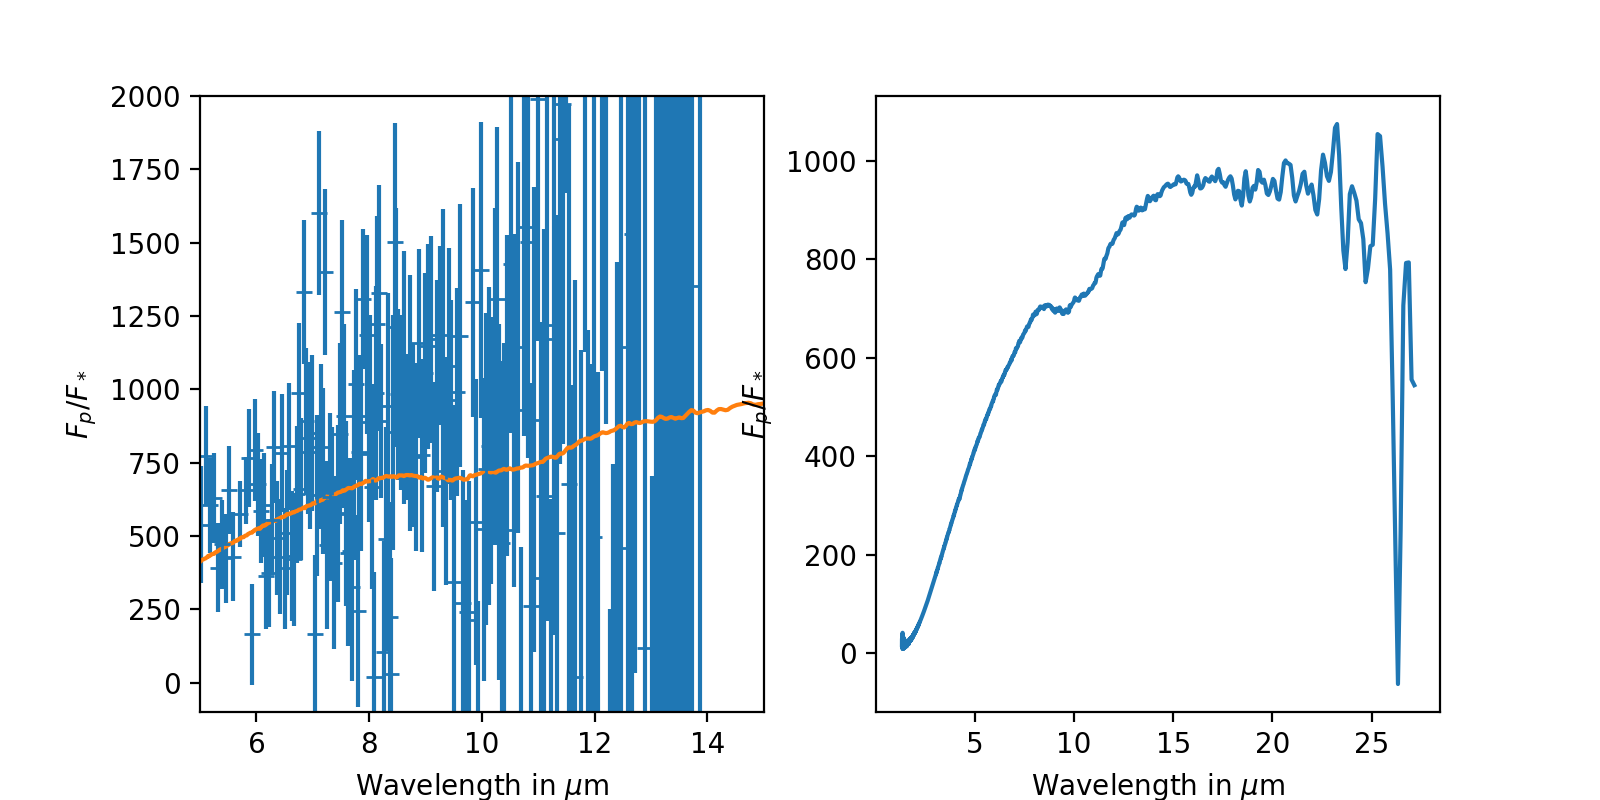

Text(0.5, 0, 'Wavelength in $\\mu$m')

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].errorbar(x[0],10**6*y[0],yerr=10**6*e[0], ls='', fmt='+')
ax[0].plot(model[:,0], 10**6*model[:,1])
ax[0].set_ylabel('$F_p/F_*$')
ax[0].set_xlabel('Wavelength in $\mu$m')
ax[0].set_xlim((5,15))
ax[0].set_ylim((-100,2000))
ax[1].plot(model[:,0], 10**6*model[:,1])
ax[1].set_ylabel('$F_p/F_*$')
ax[1].set_xlabel('Wavelength in $\mu$m')

### This does not look good. We need to decrease $R$ and increase the number of transits! Also keep in mind that in pandexo $R$ is actually $2R$

### Simulate a spectrum with N_trans=3 and R varying from 20 to 100

Also, for consistency, use the same planetary and stellar parameters as used in modelling the emission spectrum 

In [10]:
# load in output from run
out = pk.load(open('./pandexo_outputs/LHS3844b_emission_basalt_MIRI_LRS_revised.p','rb'))
# define R and N_trans parameters
R_list = [20,50,100]

x_list = []
y_list = []
e_list = []

for R in R_list:
    x,y,e = jpi.jwst_1d_spec(out, R=R/2, num_tran=3, model=True, plot=False)
    x_list.append(x)
    y_list.append(y)
    e_list.append(e)

In [11]:
# load model

model = np.loadtxt('./simulated_data/basalt.txt')

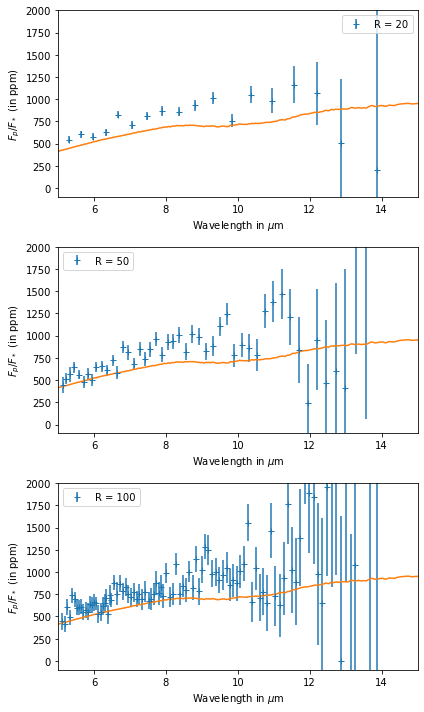

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,10))
for i,R in enumerate(R_list):
    ax[i].errorbar(x_list[i][0],10**6*y_list[i][0],yerr=10**6*e_list[i][0], ls='', fmt='+', label='R = %s'%(R))
    ax[i].plot(model[:,0], 10**6*model[:,1])
    ax[i].set_ylabel('$F_p/F_*$ (in ppm)')
    ax[i].set_xlabel('Wavelength in $\mu$m')
    ax[i].set_xlim((5,15))
    ax[i].set_ylim((-100,2000))
    ax[i].legend()
plt.tight_layout()

In [18]:
x_list[0][0][-5]/(x_list[0][0][-5] - x_list[0][0][-6])

18.753156772716125

## Re-run simulation with a modified model that uses realistic stellar spectrum rather than a blackbody assumption

In [2]:
# set up the run

exo_dict = jdi.load_exo_dict()

# exoplanet observation inputs

exo_dict['observation']['sat_level'] = 100    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = 10 #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 4*0.5212*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)


# exoplanet host star inputs

exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = 9.1            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 2.22         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 3036             #in K
exo_dict['star']['metal'] = 0.0             # as log Fe/H (don't know this value)
exo_dict['star']['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)

# exoplanet planetary inputs
exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['f_unit'] = 'fp/f*'                 # Other options are 'fp/f*'
exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'

# new dict for emission model made assuming blackbody star

exo_dict_bb = copy.deepcopy(exo_dict)
exo_dict_bb['planet']['exopath'] = './simulated_data/basalt_with_stellar_bb.txt'

# new dict for emission model made using grid model star
exo_dict_grid = copy.deepcopy(exo_dict)
exo_dict_grid['planet']['exopath'] = './simulated_data/basalt_with_stellar_grid.txt'



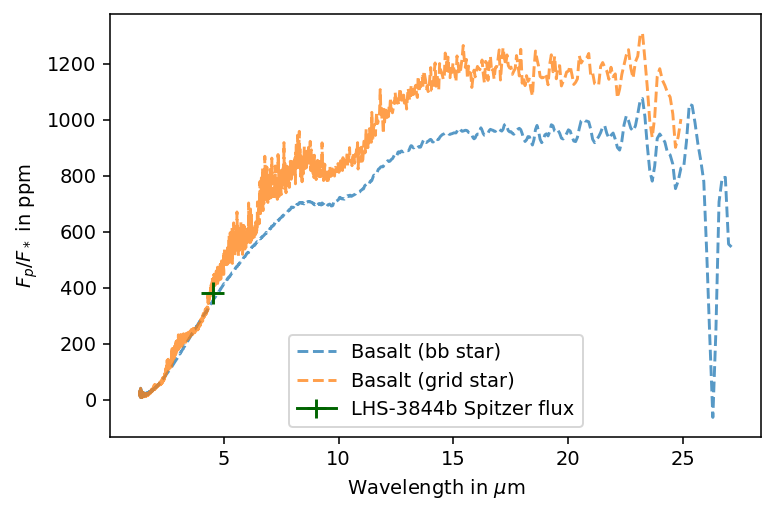

In [3]:
# plot the model files for verification

data = np.loadtxt(exo_dict_bb['planet']['exopath'])
wav_bb, spec_bb = data[:,0], data[:,1]

data = np.loadtxt(exo_dict_grid['planet']['exopath'])
wav_grid, spec_grid = data[:,0], data[:,1]

plt.figure()
plt.plot(wav_bb, spec_bb*10**6, ls='--', alpha=0.75, label='Basalt (bb star)')
plt.plot(wav_grid, spec_grid*10**6, ls='--', alpha=0.75, label='Basalt (grid star)')
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40, color='darkgreen',  label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()


Now perform pandexo simulations for both cases

In [4]:
# load instrument

inst_dict = jdi.load_mode_dict('MIRI LRS')

# run simulation for bb case

result = jdi.run_pandexo(exo_dict_bb, inst_dict, output_path = './pandexo_outputs/', output_file='LHS3844b_emission_basalt_MIRI_LRS_bb.p')

# run simulation for grid case

result = jdi.run_pandexo(exo_dict_grid, inst_dict, output_path = './pandexo_outputs/', output_file='LHS3844b_emission_basalt_MIRI_LRS_grid.p')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


Load simulated data and show it at R=20

In [5]:
R = 50

# load outputs from run
out_bb = pk.load(open('./pandexo_outputs/LHS3844b_emission_basalt_MIRI_LRS_bb.p','rb'))
x_bb,y_bb,e_bb = jpi.jwst_1d_spec(out_bb, R=R/2, num_tran=3, model=True, plot=False)

out_grid = pk.load(open('./pandexo_outputs/LHS3844b_emission_basalt_MIRI_LRS_grid.p','rb'))
x_grid,y_grid,e_grid = jpi.jwst_1d_spec(out_grid, R=R/2, num_tran=3, model=True, plot=False)

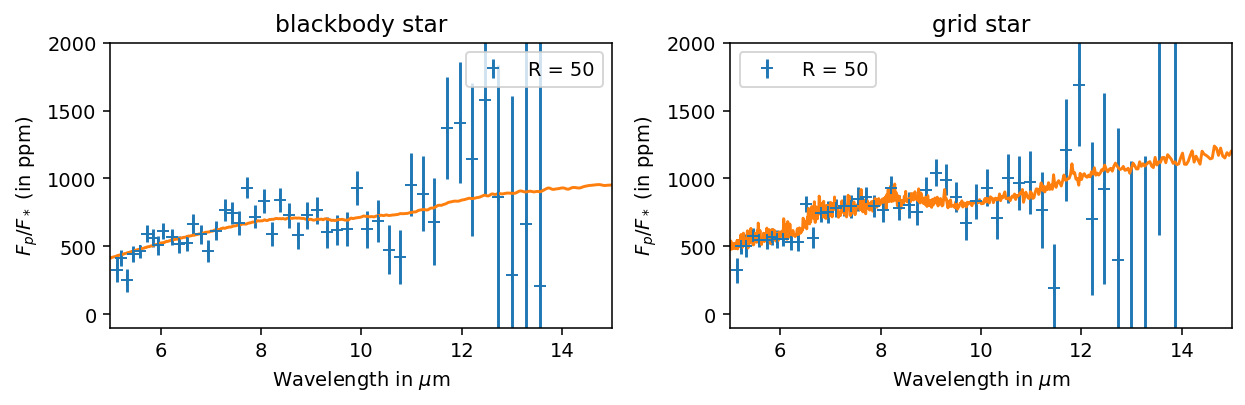

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

ax[0].errorbar(x_bb[0],10**6*y_bb[0], yerr=10**6*e_bb[0], ls='', fmt='+', label='R = %s'%(R))
ax[0].plot(wav_bb, 10**6*spec_bb)
ax[0].set_ylabel('$F_p/F_*$ (in ppm)')
ax[0].set_xlabel('Wavelength in $\mu$m')
ax[0].set_xlim((5,15))
ax[0].set_ylim((-100,2000))
ax[0].set_title('blackbody star')
ax[0].legend()

ax[1].errorbar(x_grid[0],10**6*y_grid[0], yerr=10**6*e_grid[0], ls='', fmt='+', label='R = %s'%(R))
ax[1].plot(wav_grid, 10**6*spec_grid)
ax[1].set_ylabel('$F_p/F_*$ (in ppm)')
ax[1].set_xlabel('Wavelength in $\mu$m')
ax[1].set_xlim((5,15))
ax[1].set_ylim((-100,2000))
ax[1].set_title('grid star')
ax[1].legend()

plt.tight_layout()

The simulated data still does not closely follow the model. Try using the exact same stellar file for emission modeling and pandexo simulation

In [9]:
# set up the run

exo_dict = jdi.load_exo_dict()

# exoplanet observation inputs

exo_dict['observation']['sat_level'] = 100    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = 10 #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 4*0.5212*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

# exoplanet host star inputs

exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
exo_dict['star']['starpath'] = './simulated_data/LHS3844_stellar.dat'
exo_dict['star']['w_unit'] = 'um'                      
exo_dict['star']['f_unit'] = 'Jy'      
exo_dict['star']['mag'] = 9.1            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 2.22         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)

'''
exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 3036             #in K
exo_dict['star']['metal'] = 0.0             # as log Fe/H (don't know this value)
exo_dict['star']['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
'''

# exoplanet planetary inputs
exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['f_unit'] = 'fp/f*'                 # Other options are 'fp/f*'
exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'
exo_dict['planet']['exopath'] = './simulated_data/basalt_with_stellar_grid.txt'

In [10]:
# run simulations

# load instrument

inst_dict = jdi.load_mode_dict('MIRI LRS')

# run simulation for grid case

result = jdi.run_pandexo(exo_dict, inst_dict, output_path = './pandexo_outputs/', output_file='LHS3844b_emission_basalt_MIRI_LRS_grid_2.p')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


In [21]:
R = 50

# load outputs from run
out_grid_1 = pk.load(open('./pandexo_outputs/LHS3844b_emission_basalt_MIRI_LRS_grid.p','rb'))
x_grid_1,y_grid_1,e_grid_1 = jpi.jwst_1d_spec(out_grid_1, R=R/2, num_tran=3, model=True, plot=False)

out_grid_2 = pk.load(open('./pandexo_outputs/LHS3844b_emission_basalt_MIRI_LRS_grid_2.p','rb'))
x_grid_2,y_grid_2,e_grid_2 = jpi.jwst_1d_spec(out_grid_2, R=R/2, num_tran=3, model=True, plot=False)

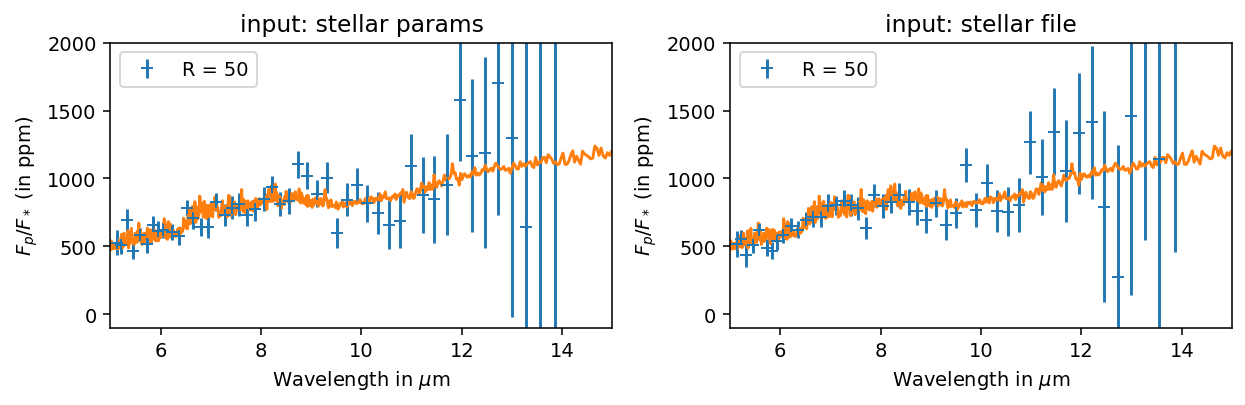

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

data = np.loadtxt(exo_dict_grid['planet']['exopath'])
wav_grid, spec_grid = data[:,0], data[:,1]

ax[0].errorbar(x_grid_1[0],10**6*y_grid_1[0], yerr=10**6*e_grid_1[0], ls='', fmt='+', label='R = %s'%(R))
ax[0].plot(wav_grid, 10**6*spec_grid)
ax[0].set_ylabel('$F_p/F_*$ (in ppm)')
ax[0].set_xlabel('Wavelength in $\mu$m')
ax[0].set_xlim((5,15))
ax[0].set_ylim((-100,2000))
ax[0].set_title('input: stellar params')
ax[0].legend()

ax[1].errorbar(x_grid_2[0],10**6*y_grid_2[0], yerr=10**6*e_grid_2[0], ls='', fmt='+', label='R = %s'%(R))
ax[1].plot(wav_grid, 10**6*spec_grid)
ax[1].set_ylabel('$F_p/F_*$ (in ppm)')
ax[1].set_xlabel('Wavelength in $\mu$m')
ax[1].set_xlim((5,15))
ax[1].set_ylim((-100,2000))
ax[1].set_title('input: stellar file')
ax[1].legend()

plt.tight_layout()

In [19]:
R = 20

# load outputs from run
out_grid_1 = pk.load(open('./pandexo_outputs/LHS3844b_emission_basalt_MIRI_LRS_grid.p','rb'))
x_grid_1,y_grid_1,e_grid_1 = jpi.jwst_1d_spec(out_grid_1, R=R/2, num_tran=3, model=True, plot=False)

out_grid_2 = pk.load(open('./pandexo_outputs/LHS3844b_emission_basalt_MIRI_LRS_grid_2.p','rb'))
x_grid_2,y_grid_2,e_grid_2 = jpi.jwst_1d_spec(out_grid_2, R=R/2, num_tran=3, model=True, plot=False)

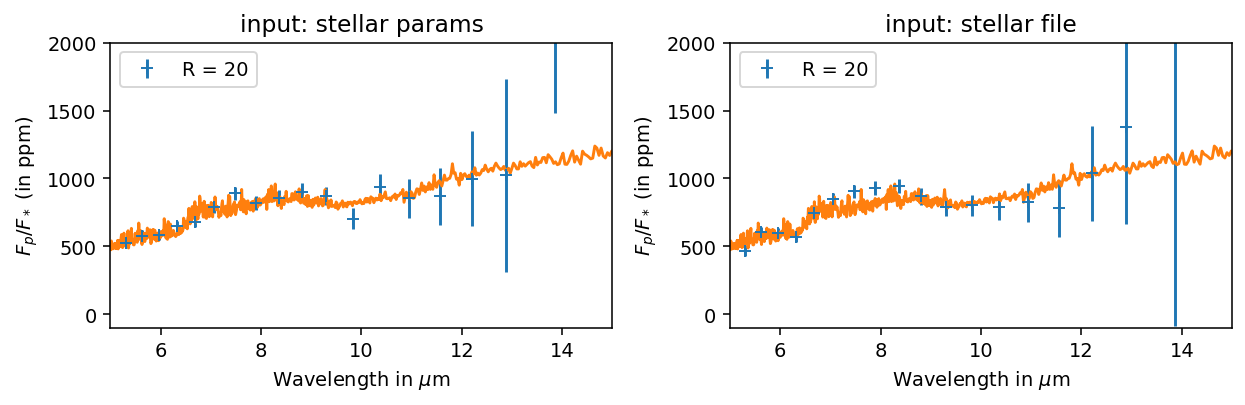

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

data = np.loadtxt(exo_dict_grid['planet']['exopath'])
wav_grid, spec_grid = data[:,0], data[:,1]

ax[0].errorbar(x_grid_1[0],10**6*y_grid_1[0], yerr=10**6*e_grid_1[0], ls='', fmt='+', label='R = %s'%(R))
ax[0].plot(wav_grid, 10**6*spec_grid)
ax[0].set_ylabel('$F_p/F_*$ (in ppm)')
ax[0].set_xlabel('Wavelength in $\mu$m')
ax[0].set_xlim((5,15))
ax[0].set_ylim((-100,2000))
ax[0].set_title('input: stellar params')
ax[0].legend()

ax[1].errorbar(x_grid_2[0],10**6*y_grid_2[0], yerr=10**6*e_grid_2[0], ls='', fmt='+', label='R = %s'%(R))
ax[1].plot(wav_grid, 10**6*spec_grid)
ax[1].set_ylabel('$F_p/F_*$ (in ppm)')
ax[1].set_xlabel('Wavelength in $\mu$m')
ax[1].set_xlim((5,15))
ax[1].set_ylim((-100,2000))
ax[1].set_title('input: stellar file')
ax[1].legend()

plt.tight_layout()

Both look good, and looks like the binning process in pandexo adds random noise. 

Let's proceed with the stellar file as input, and now perform simulations for N = 5 and 10 transits, and a R of 100

In [12]:
# set up the run

exo_dict = jdi.load_exo_dict()

# exoplanet observation inputs

exo_dict['observation']['sat_level'] = 100    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = 1 #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 4*0.5212*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

# exoplanet host star inputs

exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
exo_dict['star']['starpath'] = './simulated_data/LHS3844_stellar.dat'
exo_dict['star']['w_unit'] = 'um'                      
exo_dict['star']['f_unit'] = 'Jy'      
exo_dict['star']['mag'] = 9.1            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 2.22         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)

'''
exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 3036             #in K
exo_dict['star']['metal'] = 0.0             # as log Fe/H (don't know this value)
exo_dict['star']['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
'''

# exoplanet planetary inputs
exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['f_unit'] = 'fp/f*'                 # Other options are 'fp/f*'
exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'
exo_dict['planet']['exopath'] = './simulated_data/basalt_with_stellar_grid.txt'

In [13]:
# run simulations

# load instrument

inst_dict = jdi.load_mode_dict('MIRI LRS')

# run simulation for grid case

result = jdi.run_pandexo(exo_dict, inst_dict, output_path = './pandexo_outputs/xrp/', output_file='LHS3844b_emission_basalt_MIRI_LRS.p')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


In [14]:
R = 50

# load outputs from run
out_grid_1 = pk.load(open('./pandexo_outputs/xrp/LHS3844b_emission_basalt_MIRI_LRS.p','rb'))
x_grid_1, y_grid_1, e_grid_1 = jpi.jwst_1d_spec(out_grid_1, R=R/2, num_tran=5, model=True, plot=False)

out_grid_2 = pk.load(open('./pandexo_outputs/xrp/LHS3844b_emission_basalt_MIRI_LRS.p','rb'))
x_grid_2,y_grid_2,e_grid_2 = jpi.jwst_1d_spec(out_grid_2, R=R/2, num_tran=10, model=True, plot=False)

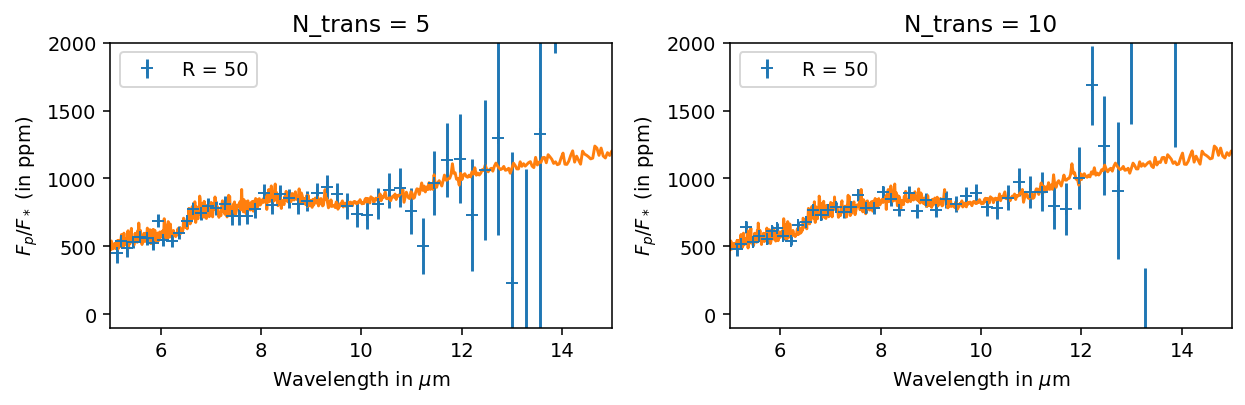

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

data = np.loadtxt(exo_dict['planet']['exopath'])
wav_grid, spec_grid = data[:,0], data[:,1]

ax[0].errorbar(x_grid_1[0],10**6*y_grid_1[0], yerr=10**6*e_grid_1[0], ls='', fmt='+', label='R = %s'%(R))
ax[0].plot(wav_grid, 10**6*spec_grid)
ax[0].set_ylabel('$F_p/F_*$ (in ppm)')
ax[0].set_xlabel('Wavelength in $\mu$m')
ax[0].set_xlim((5,15))
ax[0].set_ylim((-100,2000))
ax[0].set_title('N_trans = 5')
ax[0].legend()

ax[1].errorbar(x_grid_2[0],10**6*y_grid_2[0], yerr=10**6*e_grid_2[0], ls='', fmt='+', label='R = %s'%(R))
ax[1].plot(wav_grid, 10**6*spec_grid)
ax[1].set_ylabel('$F_p/F_*$ (in ppm)')
ax[1].set_xlabel('Wavelength in $\mu$m')
ax[1].set_xlim((5,15))
ax[1].set_ylim((-100,2000))
ax[1].set_title('N_trans = 10')
ax[1].legend()

plt.tight_layout()

Continued in `xrp_models.ipynb` notebooks